# Deep Learning model implementation

Oscar Eduardo Nieto Espitia - A01705090

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

import glob, os

# Set a random seed for reproducibility
random.seed(42)

Here, I define the path to the dataset and use the glob module to create a list of image file paths in the dataset.

The Garbage Classification Dataset is a collection of images of various types of waste items, which have been categorized into six different classes. Each class represents a specific type of garbage, and the dataset provides images for each class.

- Cardboard: 393 images
- Glass: 491 images
- Metal: 400 images
- Paper: 584 images
- Plastic: 472 images
- Trash: 127 images

In [14]:
base_path = './data/garbage classification/Garbage classification'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2527


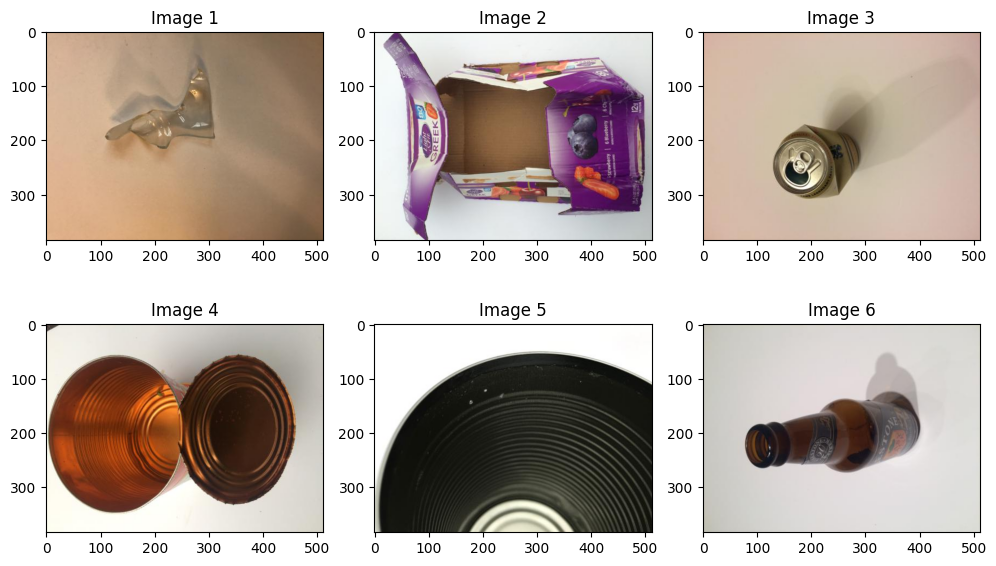

In [15]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    img_path = random.choice(img_list)
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    ax.imshow(img.squeeze())
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


## Data Augmentation

Data augmentation is used to make the training dataset more diverse, helping the model learn to handle various real-world scenarios. It's essential for the model to generalize better and make accurate predictions on unseen data. 

We just want to augment the data of the training dataset becuase the validation and test datasets are used to evaluate the model's performance. They should represent real-world, unseen data. Applying data augmentation to these datasets would defeat the purpose of testing the model's ability to generalize to new, unaltered data.

In [16]:
# Parameters for Data augmentation for the training dataset
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1,
    brightness_range=[0.7, 1.3],
    rotation_range=15
)

# Parameters for Data augmentation for the rest of the datasets (test and validation)
test_datagenerator = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Apply data augmentation for the training data
train_generator = train_datagenerator.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagenerator.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

test_generator = test_datagenerator.flow_from_directory(
	base_path,
	target_size = (150, 150),
	batch_size = 20,
	class_mode= 'categorical')

# Map class indices to class labels
labels = train_generator.class_indices
labels = {v: k for k, v in labels.items()}

# Print the class labels
print("Class Labels:")
for label_index, label_name in labels.items():
    print(f"Class {label_index}: {label_name}")

Found 2276 images belonging to 6 classes.
Found 0 images belonging to 6 classes.
Class Labels:
Class 0: cardboard
Class 1: glass
Class 2: metal
Class 3: paper
Class 4: plastic
Class 5: trash


## Model 1

In [20]:
conv_base= VGG16(weights='imagenet',
							include_top = False,
							input_shape = (300,300,3))

model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(6,activation='softmax'))

conv_base.trainable = False

model1.summary()

model1.compile(loss='categorical_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=2e-5),
               metrics=['acc']) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               10617088  
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 25333318 (96.64 MB)
Trainable params: 10618630 (40.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [22]:
history1 = model1.fit(train_generator,
				steps_per_epoch = 30,
				epochs = 50,
				validation_data = validation_generator,
				validation_steps=25,
    			verbose=1)

Epoch 1/50
30/30 [==============================] - 156s 5s/step - loss: 1.1549 - acc: 0.5667
Epoch 2/50
30/30 [==============================] - 156s 5s/step - loss: 1.1088 - acc: 0.5958
Epoch 3/50
30/30 [==============================] - 158s 5s/step - loss: 1.0691 - acc: 0.5854
Epoch 4/50
30/30 [==============================] - 156s 5s/step - loss: 0.9908 - acc: 0.6271
Epoch 5/50
30/30 [==============================] - 156s 5s/step - loss: 0.9777 - acc: 0.6125
Epoch 6/50
30/30 [==============================] - 151s 5s/step - loss: 1.0124 - acc: 0.6154
Epoch 7/50
30/30 [==============================] - 156s 5s/step - loss: 0.9611 - acc: 0.6229
Epoch 8/50
30/30 [==============================] - 157s 5s/step - loss: 0.9317 - acc: 0.6604
Epoch 9/50
30/30 [==============================] - 157s 5s/step - loss: 0.8830 - acc: 0.6438
Epoch 10/50
30/30 [==============================] - 155s 5s/step - loss: 0.9004 - acc: 0.6458
Epoch 11/50
30/30 [==============================] - 155s 5

## Model 2

In [23]:
from tensorflow.keras import regularizers

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(300, 300, 3))

conv_base.trainable = False

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

model2.summary()

model2.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(learning_rate=1e-5),
                      metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 41472)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               10617088  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 6)                 774       
                                                                 
Total params: 25365446 (96.76 MB)
Trainable params: 10

In [24]:
history2 = model2.fit(train_generator,
				steps_per_epoch = 30,
				epochs = 50,
				validation_data = validation_generator,
				validation_steps = 25)

Epoch 1/50
30/30 [==============================] - 160s 5s/step - loss: 2.3443 - accuracy: 0.2458
Epoch 2/50
30/30 [==============================] - 158s 5s/step - loss: 2.2985 - accuracy: 0.2271
Epoch 3/50
30/30 [==============================] - 158s 5s/step - loss: 2.2195 - accuracy: 0.2896
Epoch 4/50
30/30 [==============================] - 158s 5s/step - loss: 2.1652 - accuracy: 0.2750
Epoch 5/50
30/30 [==============================] - 159s 5s/step - loss: 2.0966 - accuracy: 0.3604
Epoch 6/50
30/30 [==============================] - 160s 5s/step - loss: 2.0568 - accuracy: 0.3938
Epoch 7/50
30/30 [==============================] - 161s 5s/step - loss: 2.0286 - accuracy: 0.3833
Epoch 8/50
30/30 [==============================] - 159s 5s/step - loss: 1.9625 - accuracy: 0.4146
Epoch 9/50
30/30 [==============================] - 160s 5s/step - loss: 1.9399 - accuracy: 0.4396
Epoch 10/50
30/30 [==============================] - 160s 5s/step - loss: 1.9111 - accuracy: 0.4542
Epoch 11/

In [25]:
history2 = model2.fit(train_generator,
				steps_per_epoch = 30,
				epochs = 50,
				validation_data = validation_generator,
				validation_steps = 25)

Epoch 1/50
30/30 [==============================] - 128s 4s/step - loss: 1.4747 - accuracy: 0.6208
Epoch 2/50
30/30 [==============================] - 152s 5s/step - loss: 1.4701 - accuracy: 0.6458
Epoch 3/50
30/30 [==============================] - 157s 5s/step - loss: 1.5040 - accuracy: 0.6208
Epoch 4/50
30/30 [==============================] - 151s 5s/step - loss: 1.4679 - accuracy: 0.6197
Epoch 5/50
30/30 [==============================] - 156s 5s/step - loss: 1.4353 - accuracy: 0.6396
Epoch 6/50
30/30 [==============================] - 155s 5s/step - loss: 1.4473 - accuracy: 0.6562
Epoch 7/50
30/30 [==============================] - 156s 5s/step - loss: 1.4291 - accuracy: 0.6417
Epoch 8/50
30/30 [==============================] - 155s 5s/step - loss: 1.4312 - accuracy: 0.6313
Epoch 9/50
30/30 [==============================] - 156s 5s/step - loss: 1.4522 - accuracy: 0.6197
Epoch 10/50
30/30 [==============================] - 159s 5s/step - loss: 1.4304 - accuracy: 0.6125
Epoch 11/

KeyboardInterrupt: 

In [24]:
test_x, test_y = validation_generator.__getitem__(1)

preds = model2.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

ValueError: Asked to retrieve element 1, but the Sequence has length 0